In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [60]:
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.optim import Optimizer
from pytorch_forecasting.models import DeepAR
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE,RMSE,MultivariateNormalDistributionLoss,NormalDistributionLoss
from pytorch_forecasting.data.encoders import TorchNormalizer,EncoderNormalizer
from torch.distributions.transformed_distribution import TransformedDistribution

In [61]:
use_col = ['volumn','datetime']
data = pd.read_csv('../traffic/data/3.csv',usecols=use_col)
# data.rename({'service_name':'group_ids','datetime':'b','volumn':'value','packets':'c','unknown':'d'},axis=1,inplace=True)
# data.drop(columns=['b','c','d'],inplace=True)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['group_ids']=np.tile('0',len(data))
data['time_idx']=np.arange(len(data))
data['value'] = data['value'] * 8 / 1000000
data['datetime'] = pd.to_datetime(data['datetime'])
data["day_of_week"] = data.datetime.dt.dayofweek.astype(str).astype("category")
data["week_of_year"] = data.datetime.dt.weekofyear.astype(str).astype("category")  # categories have be strings
data["month"] = data.datetime.dt.month.astype(str).astype("category")  # categories have be strings
data['time'] = np.tile(np.arange(1440),27) #1일이 1440으로 돼있으므로
data['time'] = data['time'].astype(str).astype("category") # numpy에 astype적용시 적용이 안된다
data

/tmp/ipykernel_473377/3754245401.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data["week_of_year"] = data.datetime.dt.weekofyear.astype(str).astype("category")  # categories have be strings


,datetime,value,group_ids,time_idx,day_of_week,week_of_year,month,time
0,2018-07-25 00:00:00,0.220168,0,0,2,30,7,0
1,2018-07-25 00:01:00,0.221584,0,1,2,30,7,1
2,2018-07-25 00:02:00,0.205680,0,2,2,30,7,2
3,2018-07-25 00:03:00,0.185184,0,3,2,30,7,3
4,2018-07-25 00:04:00,0.173464,0,4,2,30,7,4
...,...,...,...,...,...,...,...,...
38875,2018-08-20 23:55:00,0.166704,0,38875,0,34,8,1435
38876,2018-08-20 23:56:00,0.172936,0,38876,0,34,8,1436
38877,2018-08-20 23:57:00,0.172976,0,38877,0,34,8,1437
38878,2018-08-20 23:58:00,0.169264,0,38878,0,34,8,1438


In [62]:
data['value'].dtype

dtype('float64')

<AxesSubplot: >

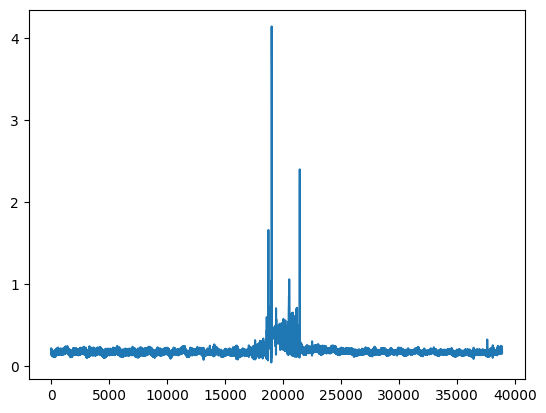

In [63]:
data['value'].plot()

In [82]:
Train_data = data.iloc[:28800]
Test_data = data.iloc[28800:]

In [83]:
encoder_length =1440
prediction_length=10080 # encoding 기간은 1일 prediction 기간은 7일

In [84]:
training = TimeSeriesDataSet(
    data=Train_data,
    max_encoder_length = encoder_length,
    min_encoder_length=1,
    max_prediction_length = prediction_length,
    min_prediction_length=prediction_length,
    target = 'value',
    #target_normalizer= TorchNormalizer(method = 'identity',center = False), # explicitly disabling normalization will cause an unexpected error
    group_ids = ['group_ids'],
    time_idx = 'time_idx',
    time_varying_known_categoricals=["week_of_year", "day_of_week","month","time"],
    #scalers = {'None':None},
    time_varying_unknown_reals = ['value'],
    time_varying_known_reals = ['time_idx'],
    min_prediction_idx=0,
    add_relative_time_idx = True,  # add as feature
    add_target_scales = True,  # add as feature
    add_encoder_length = True,  # add as feature
    categorical_encoders={
        'week_of_year':NaNLabelEncoder(add_nan=True),
        'day_of_week':NaNLabelEncoder(add_nan=True),
        'month':NaNLabelEncoder(add_nan=True),
        'time':NaNLabelEncoder(add_nan=True)
    }
# NaNLableEncoder(add_nan=True)를 쓰지 않으면 새로운 categorical 변수에 대처 불가능
# https://stackoverflow.com/questions/74621525/temporal-fusion-transformer
# https://stackoverflow.com/questions/71098518/unknown-category-2-encountered-set-add-nan-true-to-allow-unknown-categories
)

In [85]:
batch_size = 128
train_dataloader = training.to_dataloader(train=True ,batch_size = batch_size,num_workers = 4)

In [86]:
# temp2 = torch.FloatTensor()
# for i in train_dataloader:
#     i = list(i)
#     temp1 = next(iter(train_dataloader))[1][0]+0.001
#     temp2= torch.cat([temp2,temp1])
#     i[1]=temp2
#     i = tuple(i)
    
#     print(next(iter(train_dataloader)))


In [87]:
# temp2 = torch.FloatTensor()
# for i,j in train_dataloader:
#     # 마지막 까지 배치를 다 만들면 처음으로(1번째 행으로) 돌아가서 배치를 다시 만든다 
#     # 1번째행 0 0 0 0 0 ...
#     # 1번째행 2번째행 0 0 0 0 ...
#     # 1번째행 2번째행 3번째행 0 0 0 0...
#     # 위와같은 식으로 만들어진다
#     # temp = np.array(j[0].view(1,-1).squeeze(0))+0.001
#     # temp = torch.FloatTensor(temp).view(batch_size,-1)
#     temp1 = next(iter(train_dataloader))[1][0]+0.001
#     temp2= torch.cat([temp2,temp1])

# print(temp2)

In [88]:
# temp2= temp2.view(-1,batch_size,prediction_length)
# temp2.size()

In [89]:
from pytorch_lightning.callbacks import LearningRateFinder,EarlyStopping
import pytorch_lightning as pl
early_stopping = EarlyStopping(monitor = 'train_loss', min_delta = 1e-2,
                               patience = 5, verbose = True, mode = "min")
lr_find = LearningRateFinder(min_lr = 1e-10,
                            max_lr = 1,early_stop_threshold=10)
trainer = pl.Trainer(
    gpus=[0],
    gradient_clip_val=0.1,
    max_epochs=30,
    callbacks=[early_stopping,lr_find]
)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [90]:
net = DeepAR.from_dataset(training,
                         rnn_layers = 2,
                         hidden_size = 16,
                         optimizer = 'adam',
                         loss= NormalDistributionLoss() # --> MultivariateNormalDistributionLoss는 고정된 prediction length를 갖고 있어야됨
                         )

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [91]:
import torch

DEVICE = torch.device("cuda:0")

net.to(DEVICE)

DeepAR(
  	"categorical_groups":                {}
  	"cell_type":                         LSTM
  	"dropout":                           0.1
  	"embedding_labels":                  {'week_of_year': {'nan': 0, '30': 1, '31': 2, '32': 3, '33': 4}, 'day_of_week': {'nan': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7}, 'month': {'nan': 0, '7': 1, '8': 2}, 'time': {'nan': 0, '0': 1, '1': 2, '10': 3, '100': 4, '1000': 5, '1001': 6, '1002': 7, '1003': 8, '1004': 9, '1005': 10, '1006': 11, '1007': 12, '1008': 13, '1009': 14, '101': 15, '1010': 16, '1011': 17, '1012': 18, '1013': 19, '1014': 20, '1015': 21, '1016': 22, '1017': 23, '1018': 24, '1019': 25, '102': 26, '1020': 27, '1021': 28, '1022': 29, '1023': 30, '1024': 31, '1025': 32, '1026': 33, '1027': 34, '1028': 35, '1029': 36, '103': 37, '1030': 38, '1031': 39, '1032': 40, '1033': 41, '1034': 42, '1035': 43, '1036': 44, '1037': 45, '1038': 46, '1039': 47, '104': 48, '1040': 49, '1041': 50, '1042': 51, '1043': 52, '1044': 53, '1

In [92]:
model=trainer.fit(net,train_dataloaders=train_dataloader)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

Finding best initial lr:   2%|▏         | 2/100 [00:00<00:47,  2.07it/s]
`Trainer.fit` stopped: `max_steps=2` reached.
LR finder stopped early after 2 steps due to diverging loss.
Restoring states from the checkpoint path at /hdd_1/sjlee/Paper_Project/.lr_find_efa634de-8544-4925-a381-26a4ef161740.ckpt
Restored all states from the checkpoint file at /hdd_1/sjlee/Paper_Project/.lr_find_efa634de-8544-4925-a381-26a4ef161740.ckpt

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding     

Epoch 0: 100%|██████████| 157/157 [01:14<00:00,  2.11it/s, loss=-2.66, v_num=90, train_loss_step=-2.68, train_loss_epoch=-1.34]

Metric train_loss improved. New best score: -2.128


Epoch 1:   0%|          | 0/157 [00:00<?, ?it/s, loss=-2.66, v_num=90, train_loss_step=-2.68, train_loss_epoch=-2.13]          

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:447: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(


Epoch 1: 100%|██████████| 157/157 [01:14<00:00,  2.11it/s, loss=-3.1, v_num=90, train_loss_step=-3.13, train_loss_epoch=-2.13] 

Metric train_loss improved by 0.820 >= min_delta = 0.01. New best score: -2.948


Epoch 2: 100%|██████████| 157/157 [01:14<00:00,  2.11it/s, loss=-3.21, v_num=90, train_loss_step=-3.21, train_loss_epoch=-2.95]

Metric train_loss improved by 0.228 >= min_delta = 0.01. New best score: -3.176


Epoch 3: 100%|██████████| 157/157 [01:14<00:00,  2.11it/s, loss=-3.3, v_num=90, train_loss_step=-3.32, train_loss_epoch=-3.18] 

Metric train_loss improved by 0.087 >= min_delta = 0.01. New best score: -3.262


Epoch 4: 100%|██████████| 157/157 [01:14<00:00,  2.10it/s, loss=-3.37, v_num=90, train_loss_step=-3.35, train_loss_epoch=-3.26]

Metric train_loss improved by 0.077 >= min_delta = 0.01. New best score: -3.339


Epoch 5: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-3.43, v_num=90, train_loss_step=-3.44, train_loss_epoch=-3.34]

Metric train_loss improved by 0.068 >= min_delta = 0.01. New best score: -3.406


Epoch 6: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-3.49, v_num=90, train_loss_step=-3.52, train_loss_epoch=-3.41]

Metric train_loss improved by 0.060 >= min_delta = 0.01. New best score: -3.467


Epoch 7: 100%|██████████| 157/157 [01:13<00:00,  2.12it/s, loss=-3.54, v_num=90, train_loss_step=-3.54, train_loss_epoch=-3.47]

Metric train_loss improved by 0.053 >= min_delta = 0.01. New best score: -3.519


Epoch 8: 100%|██████████| 157/157 [01:14<00:00,  2.12it/s, loss=-3.6, v_num=90, train_loss_step=-3.59, train_loss_epoch=-3.52] 

Metric train_loss improved by 0.053 >= min_delta = 0.01. New best score: -3.573


Epoch 9: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-3.67, v_num=90, train_loss_step=-3.67, train_loss_epoch=-3.57]

Metric train_loss improved by 0.070 >= min_delta = 0.01. New best score: -3.642


Epoch 10: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-3.72, v_num=90, train_loss_step=-3.72, train_loss_epoch=-3.64]

Metric train_loss improved by 0.057 >= min_delta = 0.01. New best score: -3.700


Epoch 11: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-3.77, v_num=90, train_loss_step=-3.75, train_loss_epoch=-3.70]

Metric train_loss improved by 0.044 >= min_delta = 0.01. New best score: -3.744


Epoch 12: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-3.8, v_num=90, train_loss_step=-3.79, train_loss_epoch=-3.74] 

Metric train_loss improved by 0.039 >= min_delta = 0.01. New best score: -3.784


Epoch 13: 100%|██████████| 157/157 [01:13<00:00,  2.14it/s, loss=-3.83, v_num=90, train_loss_step=-3.85, train_loss_epoch=-3.78]

Metric train_loss improved by 0.035 >= min_delta = 0.01. New best score: -3.818


Epoch 14: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-3.87, v_num=90, train_loss_step=-3.84, train_loss_epoch=-3.82]

Metric train_loss improved by 0.033 >= min_delta = 0.01. New best score: -3.851


Epoch 15: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-3.89, v_num=90, train_loss_step=-3.88, train_loss_epoch=-3.85]

Metric train_loss improved by 0.028 >= min_delta = 0.01. New best score: -3.878


Epoch 16: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-3.92, v_num=90, train_loss_step=-3.90, train_loss_epoch=-3.88]

Metric train_loss improved by 0.028 >= min_delta = 0.01. New best score: -3.907


Epoch 17: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-3.94, v_num=90, train_loss_step=-3.94, train_loss_epoch=-3.91]

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: -3.929


Epoch 18: 100%|██████████| 157/157 [01:13<00:00,  2.14it/s, loss=-3.96, v_num=90, train_loss_step=-3.95, train_loss_epoch=-3.93]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: -3.950


Epoch 19: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-3.99, v_num=90, train_loss_step=-3.98, train_loss_epoch=-3.95]

Metric train_loss improved by 0.021 >= min_delta = 0.01. New best score: -3.971


Epoch 20: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-4, v_num=90, train_loss_step=-4.01, train_loss_epoch=-3.97]   

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: -3.988


Epoch 21: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-4.01, v_num=90, train_loss_step=-4.03, train_loss_epoch=-3.99]

Metric train_loss improved by 0.018 >= min_delta = 0.01. New best score: -4.007


Epoch 22: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-4.03, v_num=90, train_loss_step=-4.04, train_loss_epoch=-4.01]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: -4.022


Epoch 23: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-4.05, v_num=90, train_loss_step=-4.04, train_loss_epoch=-4.02]

Metric train_loss improved by 0.016 >= min_delta = 0.01. New best score: -4.038


Epoch 24: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-4.06, v_num=90, train_loss_step=-4.06, train_loss_epoch=-4.04]

Metric train_loss improved by 0.015 >= min_delta = 0.01. New best score: -4.053


Epoch 25: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-4.08, v_num=90, train_loss_step=-4.10, train_loss_epoch=-4.05]

Metric train_loss improved by 0.014 >= min_delta = 0.01. New best score: -4.067


Epoch 26: 100%|██████████| 157/157 [01:13<00:00,  2.14it/s, loss=-4.09, v_num=90, train_loss_step=-4.12, train_loss_epoch=-4.07]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: -4.080


Epoch 27: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-4.11, v_num=90, train_loss_step=-4.14, train_loss_epoch=-4.08]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: -4.093


Epoch 28: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, loss=-4.11, v_num=90, train_loss_step=-4.13, train_loss_epoch=-4.09]

Metric train_loss improved by 0.012 >= min_delta = 0.01. New best score: -4.105


Epoch 29: 100%|██████████| 157/157 [01:14<00:00,  2.11it/s, loss=-4.12, v_num=90, train_loss_step=-4.11, train_loss_epoch=-4.11]

Metric train_loss improved by 0.013 >= min_delta = 0.01. New best score: -4.118


Epoch 29: 100%|██████████| 157/157 [01:14<00:00,  2.11it/s, loss=-4.12, v_num=90, train_loss_step=-4.11, train_loss_epoch=-4.12]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 157/157 [01:14<00:00,  2.11it/s, loss=-4.12, v_num=90, train_loss_step=-4.11, train_loss_epoch=-4.12]


In [93]:
best_model_path = trainer.checkpoint_callback.best_model_path

In [94]:
best_model = DeepAR.load_from_checkpoint(best_model_path)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [95]:
new_encoder_data = Train_data.iloc[-encoder_length:]
new_decoder_data = Test_data.copy()
new_decoder_data['value'] = np.tile(new_encoder_data['value'].iloc[-1],len(new_decoder_data))
new_decoder_data

,datetime,value,group_ids,time_idx,day_of_week,week_of_year,month,time
28800,2018-08-14 00:00:00,0.173648,0,28800,1,33,8,0
28801,2018-08-14 00:01:00,0.173648,0,28801,1,33,8,1
28802,2018-08-14 00:02:00,0.173648,0,28802,1,33,8,2
28803,2018-08-14 00:03:00,0.173648,0,28803,1,33,8,3
28804,2018-08-14 00:04:00,0.173648,0,28804,1,33,8,4
...,...,...,...,...,...,...,...,...
38875,2018-08-20 23:55:00,0.173648,0,38875,0,34,8,1435
38876,2018-08-20 23:56:00,0.173648,0,38876,0,34,8,1436
38877,2018-08-20 23:57:00,0.173648,0,38877,0,34,8,1437
38878,2018-08-20 23:58:00,0.173648,0,38878,0,34,8,1438


In [96]:
new_prediction_data = pd.concat([new_encoder_data,new_decoder_data],ignore_index=True,axis=0)
new_raw_pred=best_model.predict(new_prediction_data , mode='prediction',return_x=False)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:317: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(


In [97]:
new_raw_pred=new_raw_pred

In [98]:
pred = np.array(new_raw_pred.view(-1))

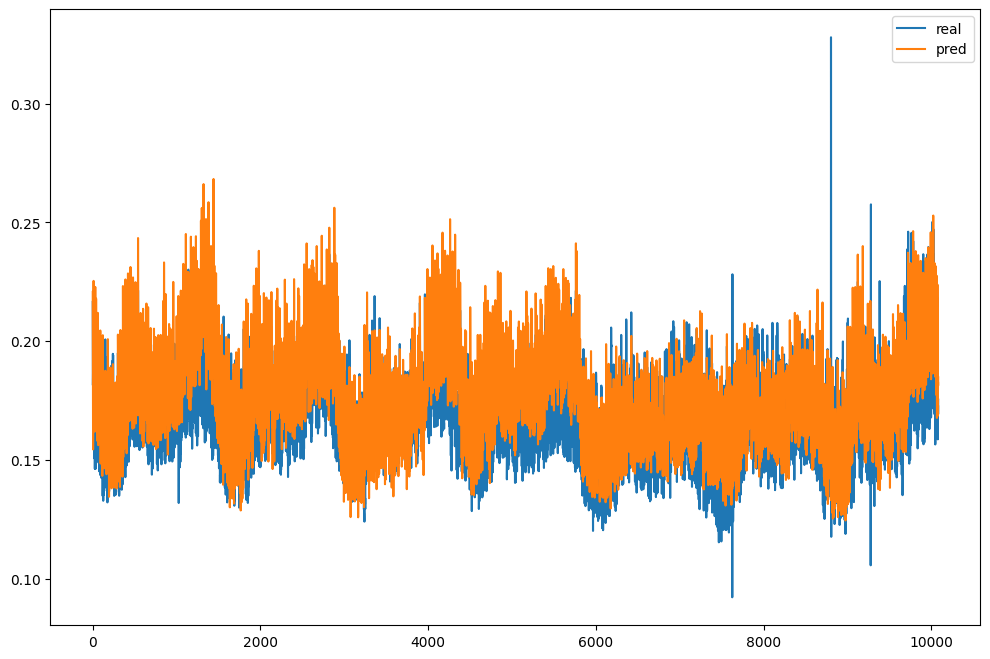

In [99]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),Test_data['value'],label='real')
axes.plot(np.arange(1,10081),pred,label='pred')
plt.legend()

In [100]:
pred

array([0.22073407, 0.20581408, 0.18870549, ..., 0.18291716, 0.18130225,
       0.18479584], dtype=float32)

In [101]:
actuals= torch.FloatTensor(Test_data['value'].values).view(1,-1)
actuals

tensor([[0.2165, 0.1943, 0.1815,  ..., 0.1730, 0.1693, 0.1754]])

In [103]:
print('smape',SMAPE()(new_raw_pred,actuals).item()*100,'%')
print('rmse',RMSE()(new_raw_pred,actuals).item())

smape 8.418978750705719 %
rmse 0.01798628456890583


https://pycj92.tistory.com/25<br>
https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/deepar.html